# Split dataset and statistics


Split the dataset generated with `generate_dataset.py` and report statistics of splits.

In [ ]:
!pip install matplotlib_venn

In [1]:
import json

SEED = 42
with open("../dataset.json", "r") as f:
    data = json.load(f)

print(len(data))

27180


In [4]:
import random
import sys

sys.path.append("..")

from plancraft.environments.planner import RECIPE_GRAPH

# seed random
random.seed(SEED)

leaves = [node for node in RECIPE_GRAPH.nodes() if RECIPE_GRAPH.out_degree(node) == 0]

# Select leave nodes as holdout targets to ensure that the model has never seen them in plans
train_targets_heldout = random.choices(leaves, k=int(len(leaves) * 0.4))
val_targets_heldout = random.choices(
    train_targets_heldout, k=int(len(train_targets_heldout) * 0.5)
)
train_targets_heldout = set(train_targets_heldout)
val_targets_heldout = set(val_targets_heldout)
print(len(train_targets_heldout), len(val_targets_heldout))

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


119 54


In [6]:
import pandas as pd
import numpy as np

np.random.seed(SEED)
df = pd.DataFrame(data)

print(len(df))
df["complexity"] = df["items_used"] * df["optimal_path_length"]
# 5 groups of difficulty
df["complexity_bin"] = pd.qcut(df["complexity"], 5, labels=False, duplicates="drop")
# 1 group of impossible
df["complexity_bin"] = df["complexity_bin"].fillna(5)
print(df["complexity_bin"].value_counts())

df["unseen_in_train"] = df["target"].isin(train_targets_heldout)
df["unseen_in_val"] = df["target"].isin(val_targets_heldout)

NUM_TRAIN_PER_COMPLEXITY = 1000
NUM_VAL_PER_COMPLEXITY = 500
NUM_TEST_PER_COMPLEXITY = 1000

train_idxs = set()
val_idxs = set()
test_idxs = set()
for group in df.groupby("complexity_bin"):
    new_train_idxs = (
        group[1]
        .loc[~group[1].target.isin(train_targets_heldout)]
        .sample(NUM_TRAIN_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    new_val_idxs = (
        group[1]
        .loc[
            ~group[1].target.isin(val_targets_heldout)
            & ~group[1].index.isin(new_train_idxs)
        ]
        .sample(NUM_VAL_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    new_test_idxs = (
        group[1]
        .loc[~group[1].index.isin(new_train_idxs) & ~group[1].index.isin(new_val_idxs)]
        .sample(NUM_TEST_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    train_idxs.update(new_train_idxs)
    val_idxs.update(new_val_idxs)
    test_idxs.update(new_test_idxs)

df.loc[list(train_idxs), "split"] = "train"
df.loc[list(val_idxs), "split"] = "val"
df.loc[list(test_idxs), "split"] = "test"


print(df["split"].value_counts())
test_df = df[df["split"] == "test"]
train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]


def subsample_df(df, total=1000):
    # ensure all targets are present
    tmp_df = (
        df.sort_values("complexity", ascending=False)
        .groupby("target")
        .first()
        .reset_index()
    )
    print(len(tmp_df))
    # sample rest of the examples randomly
    rest_df = df.loc[~df.index.isin(tmp_df.index)].sample(
        total - len(tmp_df), random_state=SEED
    )
    return pd.concat([tmp_df, rest_df])


train_df = subsample_df(train_df)
val_df = subsample_df(val_df)
test_df = subsample_df(test_df)

print(len(train_df), len(val_df), len(test_df))
print(train_df.target.nunique(), val_df.target.nunique(), test_df.target.nunique())

# save the splits
train_df.to_json("../data/train.json", orient="records")
val_df.to_json("../data/val.json", orient="records")
test_df.to_json("../data/test.json", orient="records")

27180
complexity_bin
5.0    9060
0.0    4288
1.0    4009
4.0    3619
3.0    3561
2.0    2643
Name: count, dtype: int64
split
test     6000
train    6000
val      3000
Name: count, dtype: int64
485
548
604
1000 1000 1000
485 548 604


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


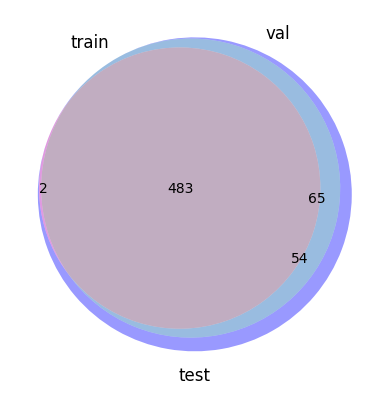

In [7]:
from matplotlib_venn import venn3

venn3(
    [set(train_df.target), set(val_df.target), set(test_df.target)],
    set_labels=["train", "val", "test"],
)

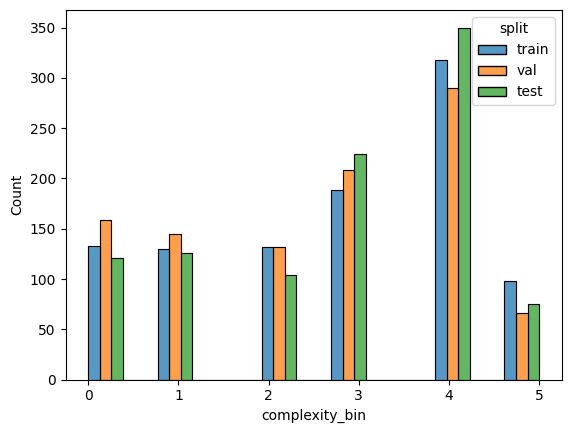

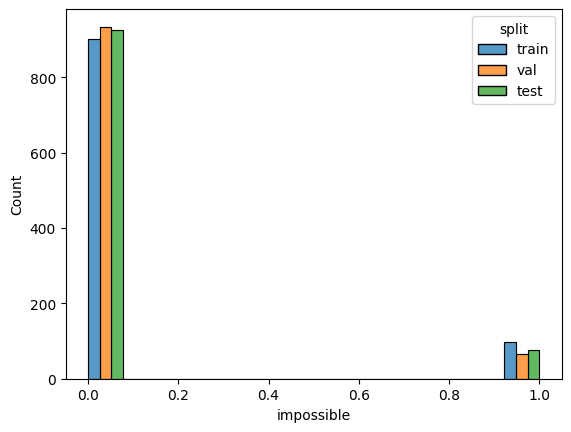

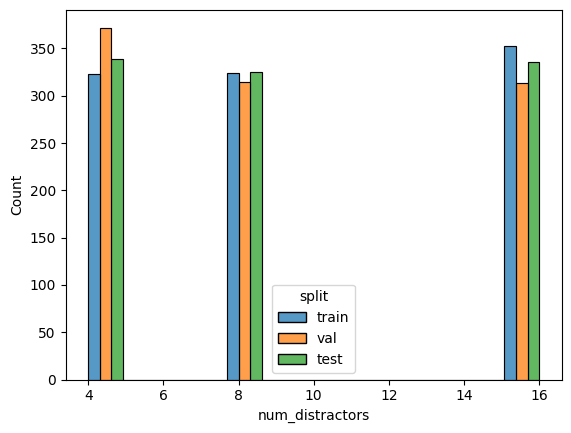

In [8]:
# df["items_used"] = df["items"].apply(len)

import seaborn as sns
import matplotlib.pyplot as plt


all_df = pd.concat([train_df, val_df, test_df])

sns.histplot(x="complexity_bin", data=all_df, hue="split", multiple="dodge")
plt.show()
sns.histplot(x="impossible", data=all_df, hue="split", multiple="dodge")
plt.show()
sns.histplot(x="num_distractors", data=all_df, hue="split", multiple="dodge")
plt.show()

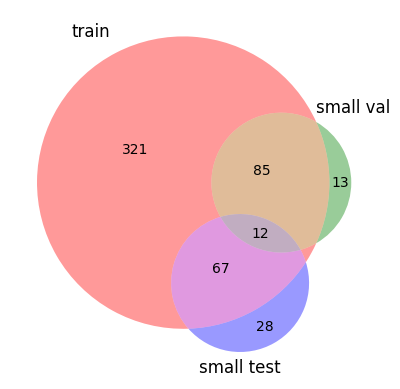

In [9]:
small_val_df = val_df.groupby("complexity_bin").sample(20, random_state=SEED)
small_test_df = test_df.groupby("complexity_bin").sample(20, random_state=SEED)

from matplotlib_venn import venn3

venn3(
    [set(train_df.target), set(small_val_df.target), set(small_test_df.target)],
    set_labels=["train", "small val", "small test"],
)

small_val_df.to_json("../data/val.small.json", orient="records")
small_test_df.to_json("../data/test.small.json", orient="records")